## Get Pypower working

In [2]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
import matplotlib as mpl
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck18 as cosmo
from astropy.stats import scott_bin_width
from scipy.interpolate import InterpolatedUnivariateSpline
from pypower import CatalogFFTPower
from tqdm import tqdm

# Set plotting style (optional, requires a style file)
mpl.style.use('./style.mcstyle')

[a839.anvil.rcac.purdue.edu:2991081] common_ucx.c:388  Warning: UCX is unable to handle VM_UNMAP event. This may cause performance degradation or data corruption. Please check OPAL memory events infrastructure.


In [3]:
def sky_to_xyz(rdz, cosmology):
    """
    Converts sky coordinates (ra, dec, z) to Cartesian coordinates (x, y, z).
    """
    ra, dec, z = np.asarray(rdz).T
    coords = SkyCoord(ra=ra*u.deg, dec=dec*u.deg,
                      distance=cosmology.comoving_distance(z))

    pos = coords.cartesian.xyz.to_value(u.Mpc) * cosmology.h
    return pos.T


def get_nofz(z, fsky, cosmo):
    """
    Calculates n(z) given redshift values and sky coverage fraction.
    This function estimates the comoving number density of objects as a
    function of redshift.
    """
    # Use Scott's rule to determine optimal bin width for the histogram
    _, edges = scott_bin_width(z, return_bins=True)

    # Count number of objects in each redshift bin
    dig = np.searchsorted(edges, z, "right")
    N = np.bincount(dig, minlength=len(edges)+1)[1:-1]

    # Calculate comoving volume of each spherical shell corresponding to a bin
    R_hi = cosmo.comoving_distance(edges[1:]).to_value(u.Mpc) * cosmo.h
    R_lo = cosmo.comoving_distance(edges[:-1]).to_value(u.Mpc) * cosmo.h
    dV = (4./3.) * np.pi * (R_hi**3 - R_lo**3) * fsky

    # Avoid division by zero for empty bins
    dV[dV == 0] = np.inf

    # Create a spline interpolator for n(z)
    nofz = InterpolatedUnivariateSpline(
        0.5*(edges[1:] + edges[:-1]), N/dV, ext='const')
    return nofz

In [37]:
# --- Configuration for Weighting ---
P0_FKP = 1e4      # Fiducial P(k) for FKP weights, in (Mpc/h)^3
fsky = 1./8         # Sky fraction of the survey, adjust as needed

# --- File Paths ---
data_file = '/anvil/scratch/x-mho1/cmass-ili/mtng/nbody/L3000-N384/0/mtng_lightcone/hod00000_aug00000.h5'
randoms_file = '/anvil/scratch/x-mho1/cmass-ili/abacus/randoms/L2000-N256/11/mtng_lightcone/hod00000_aug00000.h5'

# --- Load Raw Data (RA, Dec, Redshift) ---
with h5py.File(data_file, 'r') as f:
    data_rdz = np.array([f['ra'][:], f['dec'][:], f['z'][:]]).T
with h5py.File(randoms_file, 'r') as f:
    randoms_rdz = np.array([f['ra'][:], f['dec'][:], f['z'][:]]).T

print(f"Loaded {len(data_rdz)} data galaxies and {len(randoms_rdz)} randoms.")

# --- Prepare Position Arrays ---
data_positions = sky_to_xyz(data_rdz, cosmo).T
randoms_positions = sky_to_xyz(randoms_rdz, cosmo).T

# --- Prepare All Potential Weight Arrays ---
# 1. Uniform weights
uniform_data_weights = np.ones(data_positions.shape[1])
uniform_randoms_weights = np.ones(randoms_positions.shape[1])

# 2. FKP weights
print(f"Pre-calculating FKP weights with P0 = {P0_FKP}...")
nofz_estimator = get_nofz(data_rdz[:, 2], fsky=fsky, cosmo=cosmo)
n_data = nofz_estimator(data_rdz[:, 2])
n_randoms = nofz_estimator(randoms_rdz[:, 2])
fkp_data_weights = 1.0 / (1.0 + n_data * P0_FKP)
fkp_randoms_weights = 1.0 / (1.0 + n_randoms * P0_FKP)
print("FKP weights are ready.")

Loaded 790149 data galaxies and 530539 randoms.
Pre-calculating FKP weights with P0 = 10000.0...
FKP weights are ready.


In [46]:
# --- 1. Define Default Parameters ---
default_params = dict(
    use_fkp=False,
    resampler='tsc',
    interlacing=2,
    cellsize=1000/128,
    boxpad=1.2,
    los='x',
    position_type='xyz'
)

# --- 2. Define Specific Configurations ---
# You can now directly compare weighted vs. unweighted runs.
configs = [
    dict(name=r'$P_0=$1e4',
         params=dict(use_fkp=True)),
]

# --- 3. Run Calculations and Store Results ---
# results = {}
kedges = np.arange(0, 0.5, 0.00314)
ells = (0, 2, 4)

for config in tqdm(configs):
    name = config['name']

    # Create the final parameters by updating defaults with specific changes
    final_params = default_params.copy()
    final_params.update(config['params'])

    # Pop 'use_fkp' as it's not a pypower argument, and select weights
    if final_params.pop('use_fkp'):
        print(f"--- Running: {name} (using FKP weights) ---")
        data_w, randoms_w = fkp_data_weights, fkp_randoms_weights
    else:
        print(f"--- Running: {name} (using Uniform weights) ---")
        data_w, randoms_w = uniform_data_weights, uniform_randoms_weights

    result = CatalogFFTPower(
        data_positions1=data_positions,
        data_weights1=data_w,
        randoms_positions1=randoms_positions,
        randoms_weights1=randoms_w,
        edges=kedges,
        ells=ells,
        **final_params  # Unpack the remaining, valid pypower parameters
    )
    results[name] = result.poles

  0%|          | 0/1 [00:00<?, ?it/s]

--- Running: $P_0=$1e4 (using FKP weights) ---


100%|██████████| 1/1 [00:06<00:00,  6.58s/it]


$P_0=$1e4 (Baseline)
$P_0=$1e5


/home/x-mho1/.conda/envs/2024.02-py311/pmesh/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/x-mho1/.conda/envs/2024.02-py311/pmesh/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/x-mho1/.conda/envs/2024.02-py311/pmesh/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/x-mho1/.conda/envs/2024.02-py311/pmesh/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


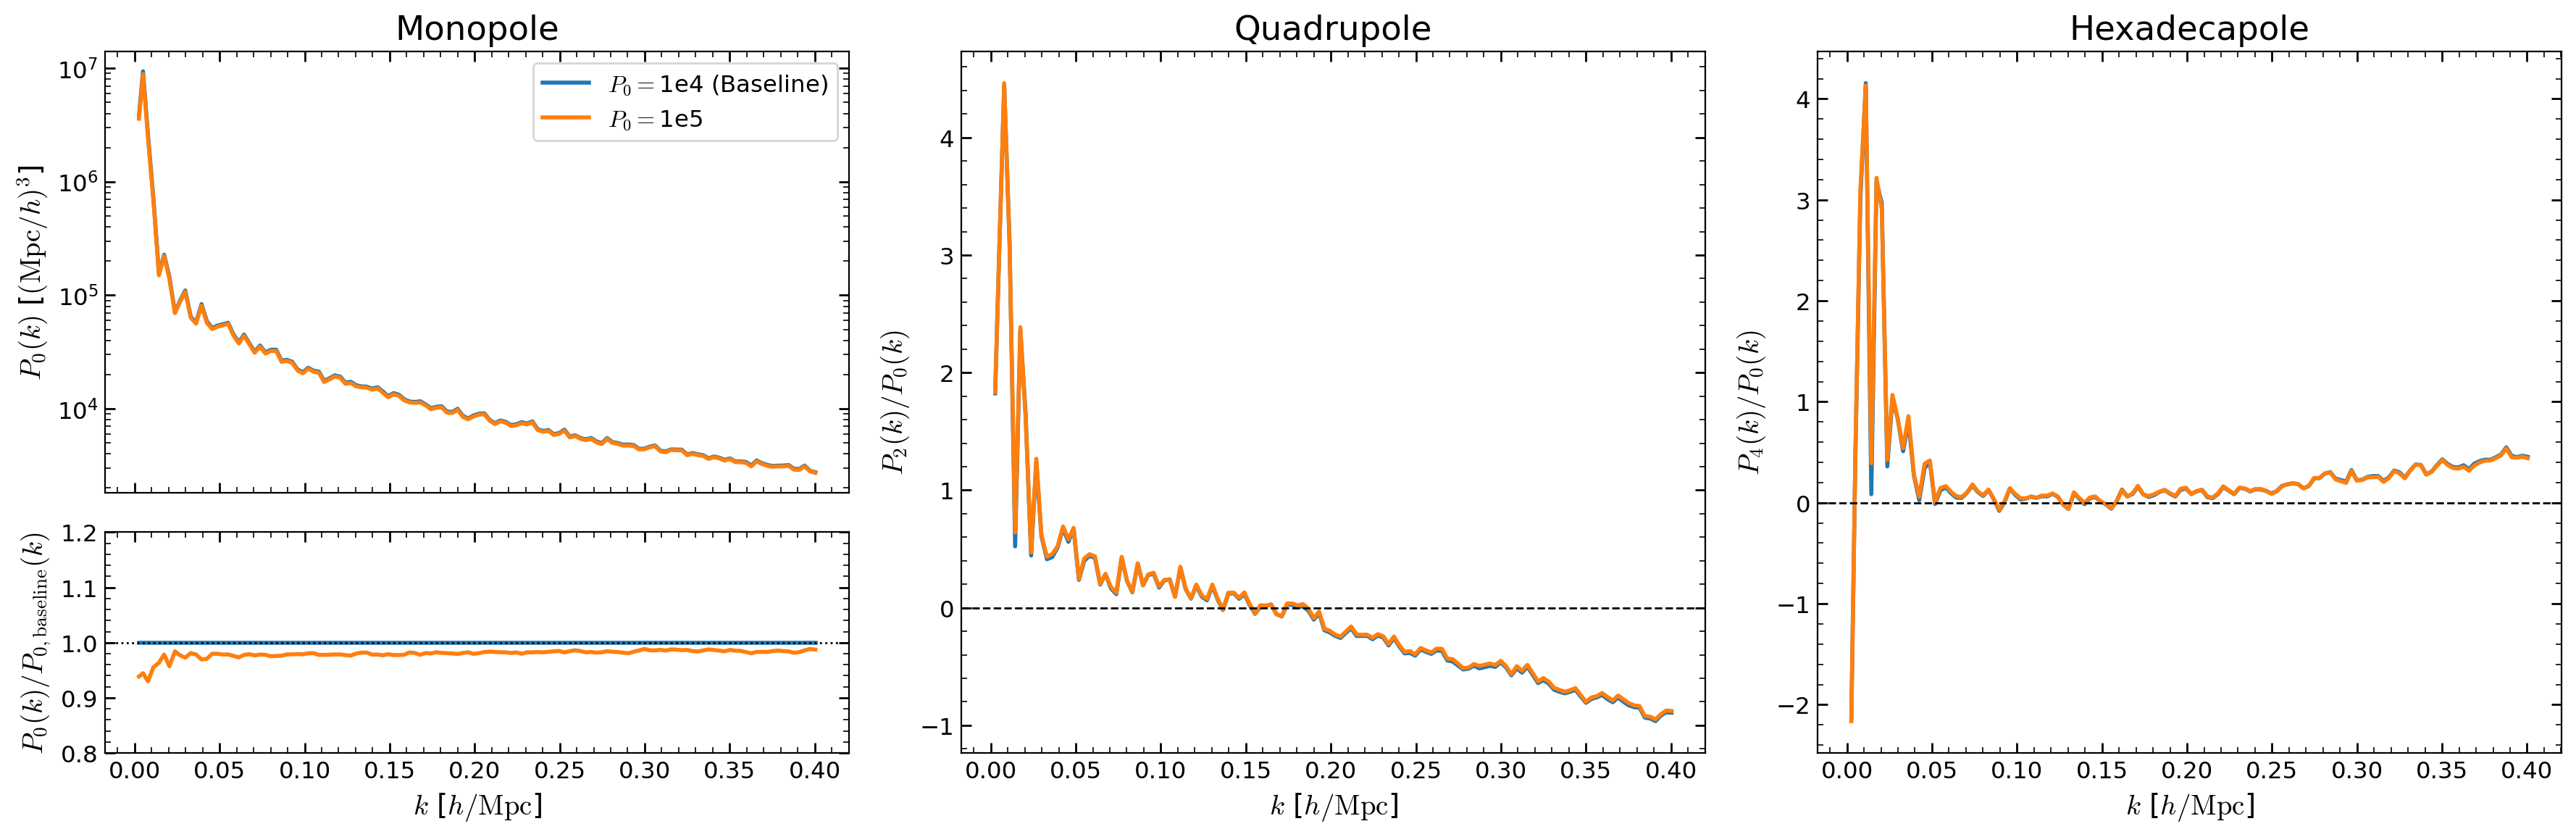

In [ ]:
from matplotlib import gridspec

# --- 1. Create Figure with a custom GridSpec layout ---
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 3, height_ratios=[2, 1])

# Create the axes for the four plots
ax_pk0 = fig.add_subplot(gs[0, 0])          # Top-left for raw monopole
ax_ratio = fig.add_subplot(gs[1, 0], sharex=ax_pk0)  # Bottom-left for ratio
ax_pk2 = fig.add_subplot(gs[:, 1])          # Middle, spanning both rows
ax_pk4 = fig.add_subplot(gs[:, 2])          # Right, spanning both rows

# Hide x-tick labels on the top-left plot to avoid overlap
plt.setp(ax_pk0.get_xticklabels(), visible=False)

# --- 2. Define a Baseline for Comparison ---
# configs[0]['name']
baseline_name = '$P_0=$1e4 (Baseline)'  # configs[0]['name']
k_base, pk0_base = results[baseline_name](ell=0, return_k=True)

# --- 3. Loop Through and Plot Each Result ---
for name, poles in results.items():
    print(name)
    k, pk0 = poles(ell=0, return_k=True)
    _, pk2 = poles(ell=2, return_k=True)
    _, pk4 = poles(ell=4, return_k=True)

    # Plot 1a: Raw Monopole (top-left)
    ax_pk0.plot(k, pk0, label=name)

    # Plot 1b: Monopole Ratio (bottom-left)
    ax_ratio.plot(k, pk0 / pk0_base)

    # Plot 2: Quadrupole / Monopole (middle)
    ax_pk2.plot(k, pk2 / pk0)

    # Plot 3: Hexadecapole / Monopole (right)
    ax_pk4.plot(k, pk4 / pk0)

# --- 4. Finalize Plot Formatting ---
# Raw Monopole Plot
ax_pk0.set_title('Monopole')
ax_pk0.set_ylabel(r'$P_0(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
ax_pk0.legend()
ax_pk0.semilogy()

# Monopole Ratio Plot
ax_ratio.set_ylabel(r'$P_0(k) / P_{0, \mathrm{baseline}}(k)$')
ax_ratio.axhline(1, color='k', linestyle=':', lw=1)
ax_ratio.set_ylim(0.8, 1.2)  # Zoom in to see small differences
ax_ratio.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')

# Quadrupole Plot
ax_pk2.set_title('Quadrupole')
ax_pk2.set_ylabel(r'$P_2(k) / P_0(k)$')
ax_pk2.axhline(0, color='k', linestyle='--', lw=1)
ax_pk2.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')

# Hexadecapole Plot
ax_pk4.set_title('Hexadecapole')
ax_pk4.set_ylabel(r'$P_4(k) / P_0(k)$')
ax_pk4.axhline(0, color='k', linestyle='--', lw=1)
ax_pk4.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

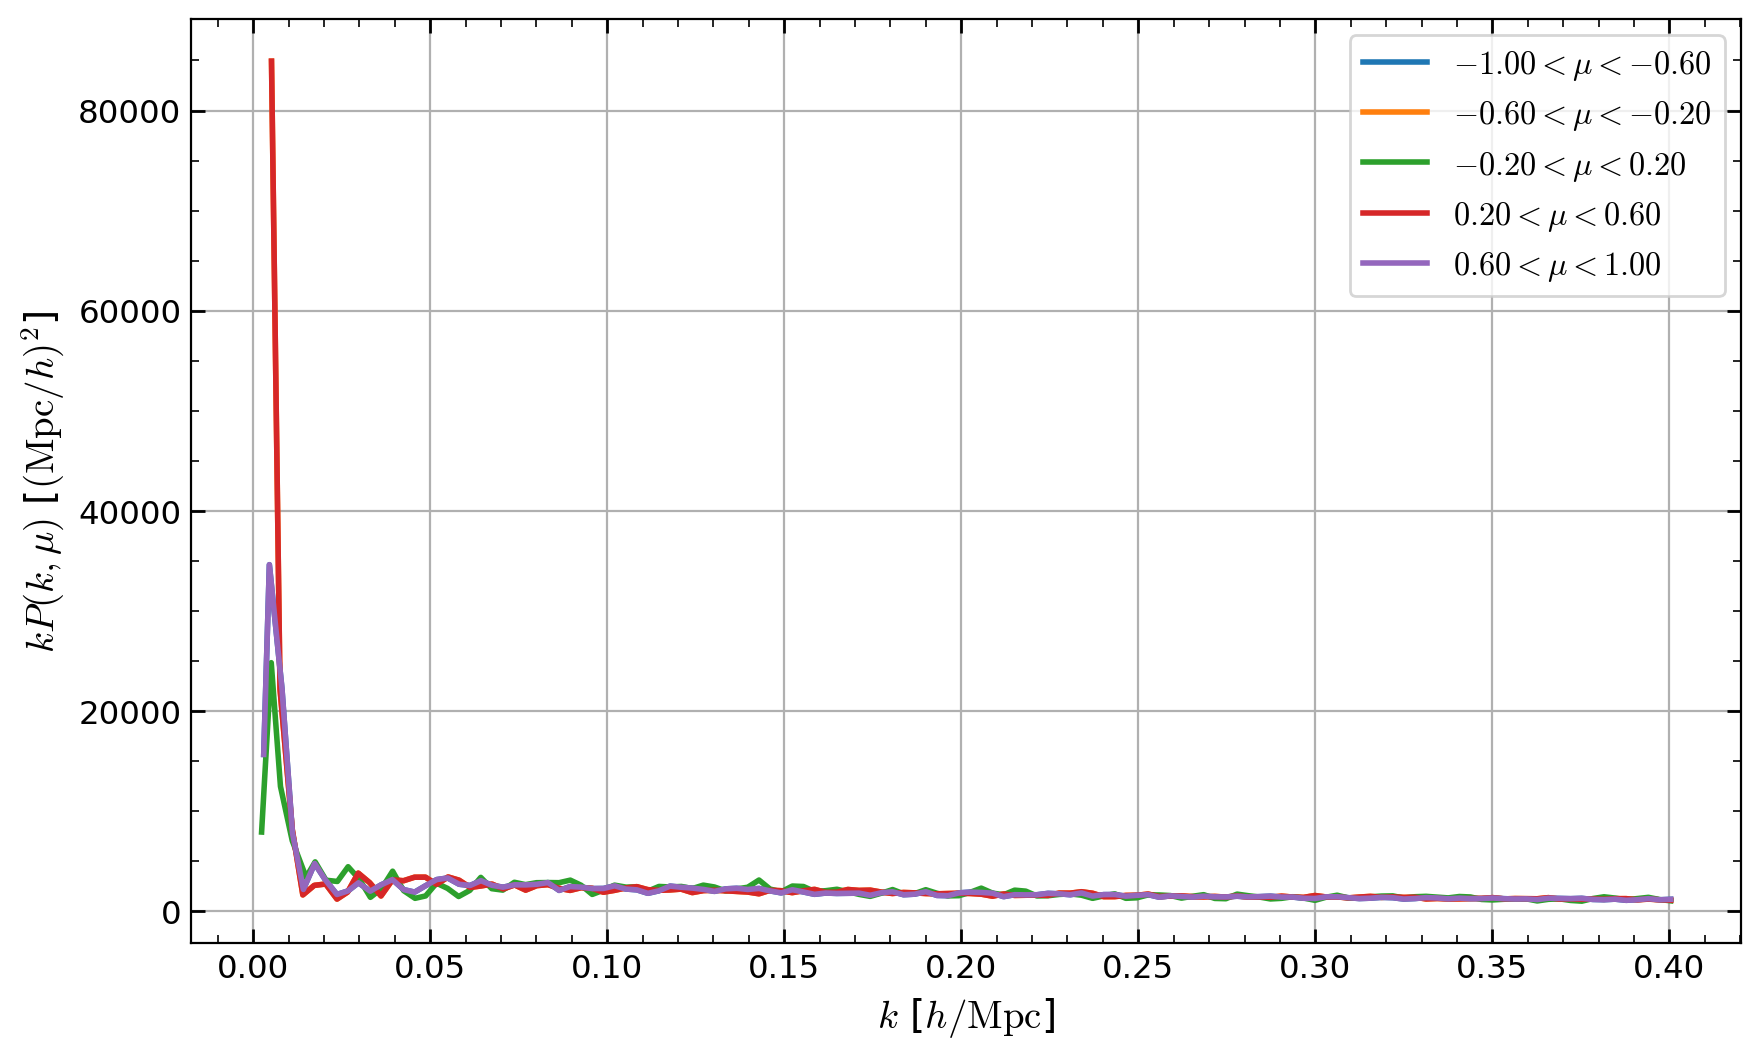

In [ ]:
result = CatalogFFTPower(
    data_positions1=data_positions,
    data_weights1=data_w,
    randoms_positions1=randoms_positions,
    randoms_weights1=randoms_w,
    edges=(kedges, np.linspace(-1, 1, 6)),
    ells=ells,
    **final_params  # Unpack the remaining, valid pypower parameters
)
result.wedges.plot(show=True)

/home/x-mho1/.conda/envs/2024.02-py311/pmesh/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/x-mho1/.conda/envs/2024.02-py311/pmesh/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


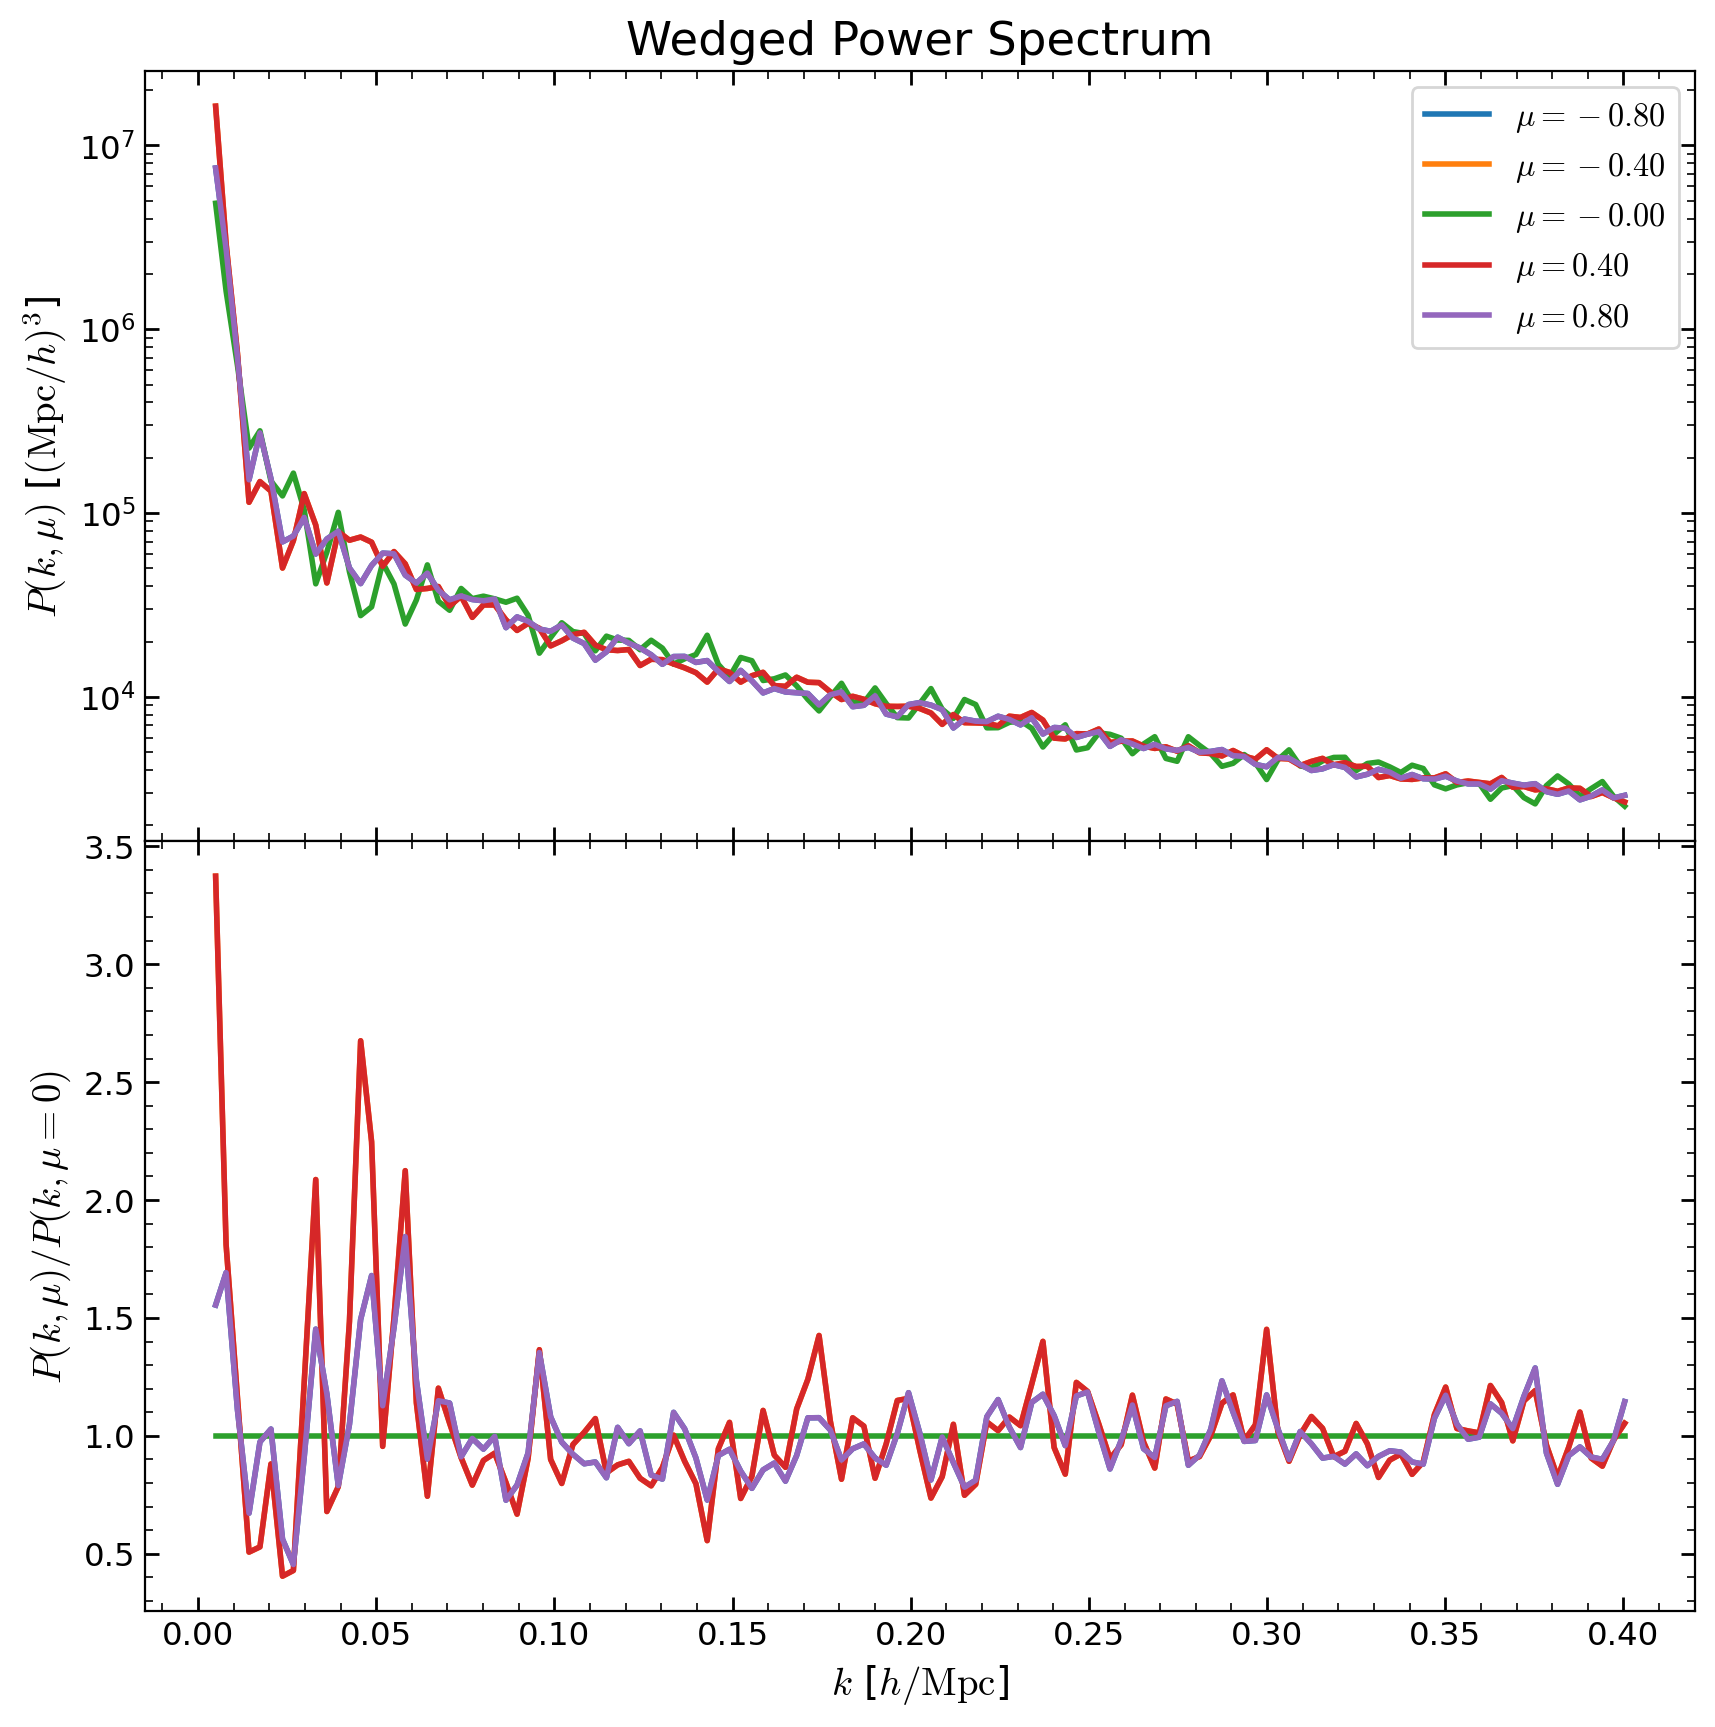

In [ ]:
wedges = result.wedges

baseline = wedges(mu=0, return_k=False)
f, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True,
                      gridspec_kw=dict(hspace=0))
for imu, mu in enumerate(wedges.muavg):
    ax = axs[0]
    ax.plot(*wedges(mu=mu, return_k=True, complex=False),
            label=r'$\mu = {:.2f}$'.format(mu))

    ax = axs[1]
    k, pk = wedges(mu=mu, return_k=True, complex=False)
    ax.plot(k, pk/baseline, label=r'$\mu = {:.2f}$'.format(mu))

axs[0].semilogy()
axs[0].set_title('Wedged Power Spectrum')
axs[0].set_ylabel(r'$P(k, \mu)$ [$(\mathrm{Mpc}/h)^{3}$]')
axs[1].set_ylabel(r'$P(k, \mu) / P(k, \mu=0)$')
axs[1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
axs[0].legend()